In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt    
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

In [2]:
train = pd.read_csv('hptrain.csv')
test = pd.read_csv('hptest.csv')

print("Train:", train.shape, "Test:",test.shape)

Train: (1460, 81) Test: (1459, 80)


In [79]:
train.head()
#test.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,encStreet,encCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,2,2008,WD,Normal,208500,1,0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,5,2007,WD,Normal,181500,1,0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,9,2008,WD,Normal,223500,1,0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,2,2006,WD,Abnorml,140000,1,0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,12,2008,WD,Normal,250000,1,0


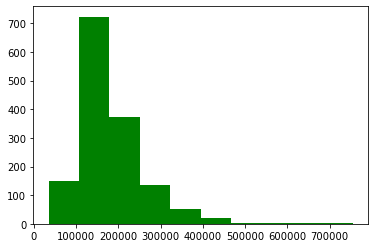

In [4]:
# skew = degree of distortion from a normal distribution, มีค่าของบางอันสูงเกินไป ต้อง transform ค่า
plt.hist(train.SalePrice, color='green')
plt.show()

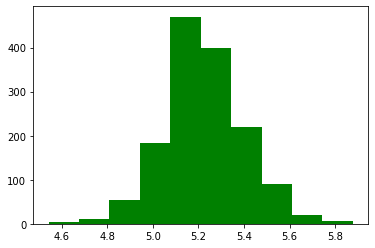

In [6]:
#transformed with log
traintf = np.log10(train.SalePrice) #will be used later
plt.hist(traintf, color='green')
plt.show()

In [7]:
#check closest correlations
features = train.select_dtypes(include=[np.number])
cor = features.corr()
print('Positive Correlation')
print (cor['SalePrice'].sort_values(ascending=False)[:10], '\n')  # positive correlate
print('Negative Correlation')
print (cor['SalePrice'].sort_values(ascending=False)[-10:])       # negative

Positive Correlation
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64 

Negative Correlation
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


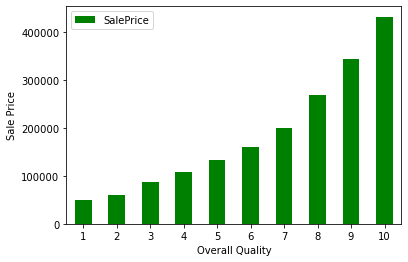

In [8]:
#Sale Price Quality Check
quality = train.pivot_table(index='OverallQual', values='SalePrice', aggfunc=np.median)
quality.plot(kind='bar', color='green')
plt.xlabel('Overall Quality')
plt.ylabel('Sale Price')
plt.xticks(rotation=0)
plt.show()

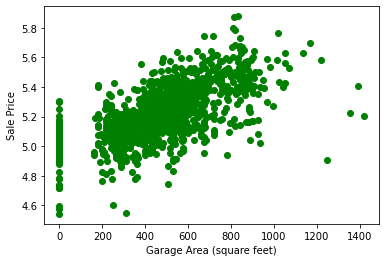

In [10]:
#Check with living area
plt.scatter(x=train['GarageArea'], y=traintf,c='g')
plt.ylabel('Sale Price')
plt.xlabel('Garage Area (square feet)')
plt.show()

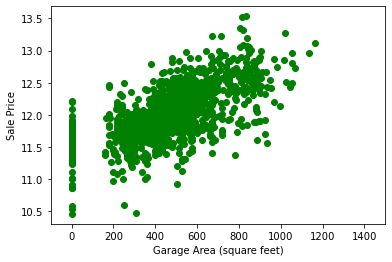

In [11]:
#Without Outliers
train = train[train['GarageArea'] < 1200]
plt.scatter(x=train['GarageArea'], y=np.log(train.SalePrice),c='g')
plt.xlim(-100,1500) 
plt.ylabel('Sale Price')
plt.xlabel('Garage Area (square feet)')
plt.show()


In [12]:
#Remove outlier
train = train[train['GrLivArea'] < 4000]
train = train[train['GarageArea'] < 1200]
train = train[train['TotalBsmtSF'] < 2500]
train = train[train['1stFlrSF'] < 2500]


In [13]:
#category detail
categoricals = train.select_dtypes(exclude=[np.number])
print("Non numeric\n",categoricals.describe())

Non numeric
        MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
count      1445   1445    91     1445        1445      1445      1445   
unique        5      2     2        4           4         2         5   
top          RL   Pave  Grvl      Reg         Lvl    AllPub    Inside   
freq       1137   1440    50      918        1300      1444      1042   

       LandSlope Neighborhood Condition1  ... GarageType GarageFinish  \
count       1445         1445       1445  ...       1364         1364   
unique         3           25          9  ...          6            3   
top          Gtl        NAmes       Norm  ...     Attchd          Unf   
freq        1368          225       1249  ...        858          605   

       GarageQual GarageCond PavedDrive PoolQC  Fence MiscFeature SaleType  \
count        1364       1364       1445      5    279          53     1445   
unique          5          5          3      3      4           4        9   
top            TA    

In [14]:
print ("Endode Street Type")
print (train.Street.value_counts(), "\n")
train['encStreet'] = pd.get_dummies(train.Street, drop_first=True)
test['encStreet'] = pd.get_dummies(test.Street, drop_first=True)
print ('Encoded:')
print (train.encStreet.value_counts())

Endode Street Type
Pave    1440
Grvl       5
Name: Street, dtype: int64 

Encoded:
1    1440
0       5
Name: encStreet, dtype: int64


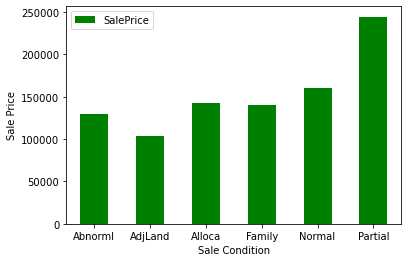

In [15]:
#sale price per condition
condition_pivot = train.pivot_table(index='SaleCondition', values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='green')
plt.xlabel('Sale Condition')
plt.ylabel('Sale Price')
plt.xticks(rotation=0)
plt.show()

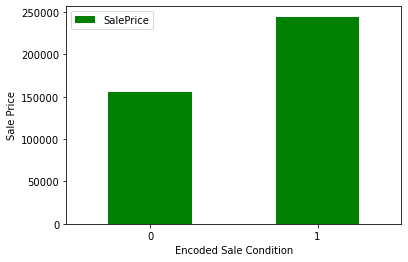

In [16]:
#encode, focusing on Partial condition
def encode(x): return 1 if x == 'Partial' else 0
train['encCondition'] = train.SaleCondition.apply(encode)
test['encCondition'] = test.SaleCondition.apply(encode)

condition_pivot = train.pivot_table(index='encCondition', values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='green')
plt.xlabel('Encoded Sale Condition')
plt.ylabel('Sale Price')
plt.xticks(rotation=0)
plt.show()


In [17]:
# check nulls amount
null = pd.DataFrame(train.isnull().sum().sort_values(ascending=False)[:25])
null.columns = ['Null Counts']
#nulls
print(null)

              Null Counts
PoolQC               1440
MiscFeature          1392
Alley                1354
Fence                1166
FireplaceQu           689
LotFrontage           254
GarageQual             81
GarageCond             81
GarageType             81
GarageYrBlt            81
GarageFinish           81
BsmtExposure           38
BsmtQual               37
BsmtCond               37
BsmtFinType2           37
BsmtFinType1           37
MasVnrArea              7
MasVnrType              7
Electrical              1
RoofMatl                0
RoofStyle               0
ExterQual               0
Exterior1st             0
Exterior2nd             0
YearBuilt               0


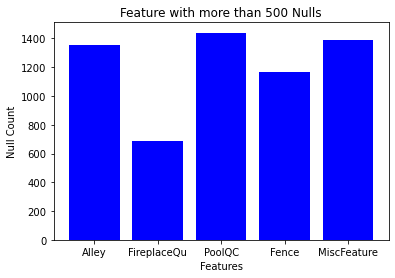

In [18]:
features = []
nulls = []
for i in train:
    if (train.isnull().sum()[i])>500 and i!='SalePrice':
        features.append(i)
        nulls.append(train.isnull().sum()[i])
ypos = np.arange(len(features)) 
plt.bar(ypos, nulls, color='blue')
plt.xticks(ypos, features)
plt.ylabel('Null Count')
plt.xlabel('Features')
plt.title('Feature with more than 500 Nulls')
plt.show()

In [24]:
#fill the missing data with interpolation (fill missing with average)
data = train.select_dtypes(include=[np.number]).interpolate().dropna()
#check column with null
print('Null count now :',sum(data.isnull().sum() != 0))

Null count now : 0


In [77]:
#build linear model
X = data.drop(['SalePrice', 'Id'], axis=1)
Y = np.log(train.SalePrice)
# must have fixed random state otherwise it will be random, 42 best universal value but 44 give us best result
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, random_state=44, test_size=.30)
lmr = linear_model.LinearRegression(normalize=True)
model = lmr.fit(X_train, Y_train)
predictions = model.predict(X_test)
print("R^2  : ", model.score(X_test, Y_test))
print('RMSE : ', mean_squared_error(Y_test, predictions))
# 0.8890060249035496   0.017587448424327357  old
# 0.8892414034974347   0.01785201486328915  14600
# 0.9026649739088134   0.015870894933922537 14595W
# 0.9083386673951772   0.015028626644323664 14224

R^2  :  0.908334883505767
RMSE :  0.015029247044001418


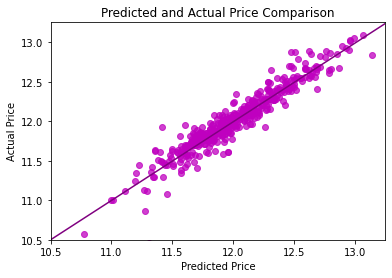

In [64]:
#Result
actual_values = Y_test
fig, ax = plt.subplots()
ax.scatter(predictions, actual_values, alpha=.75, color='m') 
plt.xlim(10.5,13.25)
plt.ylim(10.5,13.25)     
line = mlines.Line2D([0, 1.005], [0, 1], color='purple')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Predicted and Actual Price Comparison')
plt.show()

In [65]:
#submit
submission = pd.DataFrame()

submission['Id'] = test.Id
feats = test.select_dtypes(
    include=[np.number]).drop(['Id'], axis=1).interpolate()

predictions = model.predict(feats)
final_predictions = np.exp(predictions)

print("Original predictions: \n", predictions[:10], "\n")
print("Final predictions: \n", final_predictions[:10])
submission['SalePrice'] = final_predictions

Original predictions: 
 [11.71591181 11.59327128 12.07804972 12.18835636 12.08347967 12.04332428
 12.14966228 11.98643083 12.15849161 11.65995574] 

Final predictions: 
 [122505.57395174 108366.17484209 175966.64193093 196487.9444823
 176924.72974311 169961.00061675 189030.24016355 160561.25935117
 190706.64092491 115838.90314282]


In [66]:
submission.to_csv('submission.csv', index=False)